In [1]:
import astropy . io . fits as fits
import astropy . constants as const
import astropy . units as u
import numpy as np
import matplotlib . pyplot as plt
from matplotlib . ticker import ( MultipleLocator , AutoMinorLocator )
from mpl_toolkits . axes_grid1 . inset_locator import ( inset_axes ,
InsetPosition , mark_inset )
import scipy . interpolate as interp
from matplotlib import cm
import matplotlib 

In [2]:
#code provided by the lab manual
def read_opacity(f):
    block = fits.getdata(f)
    T = block [: ,0][1:]
    wl = block [0][1:]
    K = block [1: ,1:]
    return ( wl ,K , T )
# Element 0 ,0 is a dummy value equal to zero .
wl , K_H2O , T_axis = read_opacity ("H2O_opacity.fits")
wl , K_CO2 , T_axis = read_opacity ("CO2_opacity.fits")
wl = wl /1000 # transform nm to micro-m

Opacities versus temperature visualization (partially provided code)

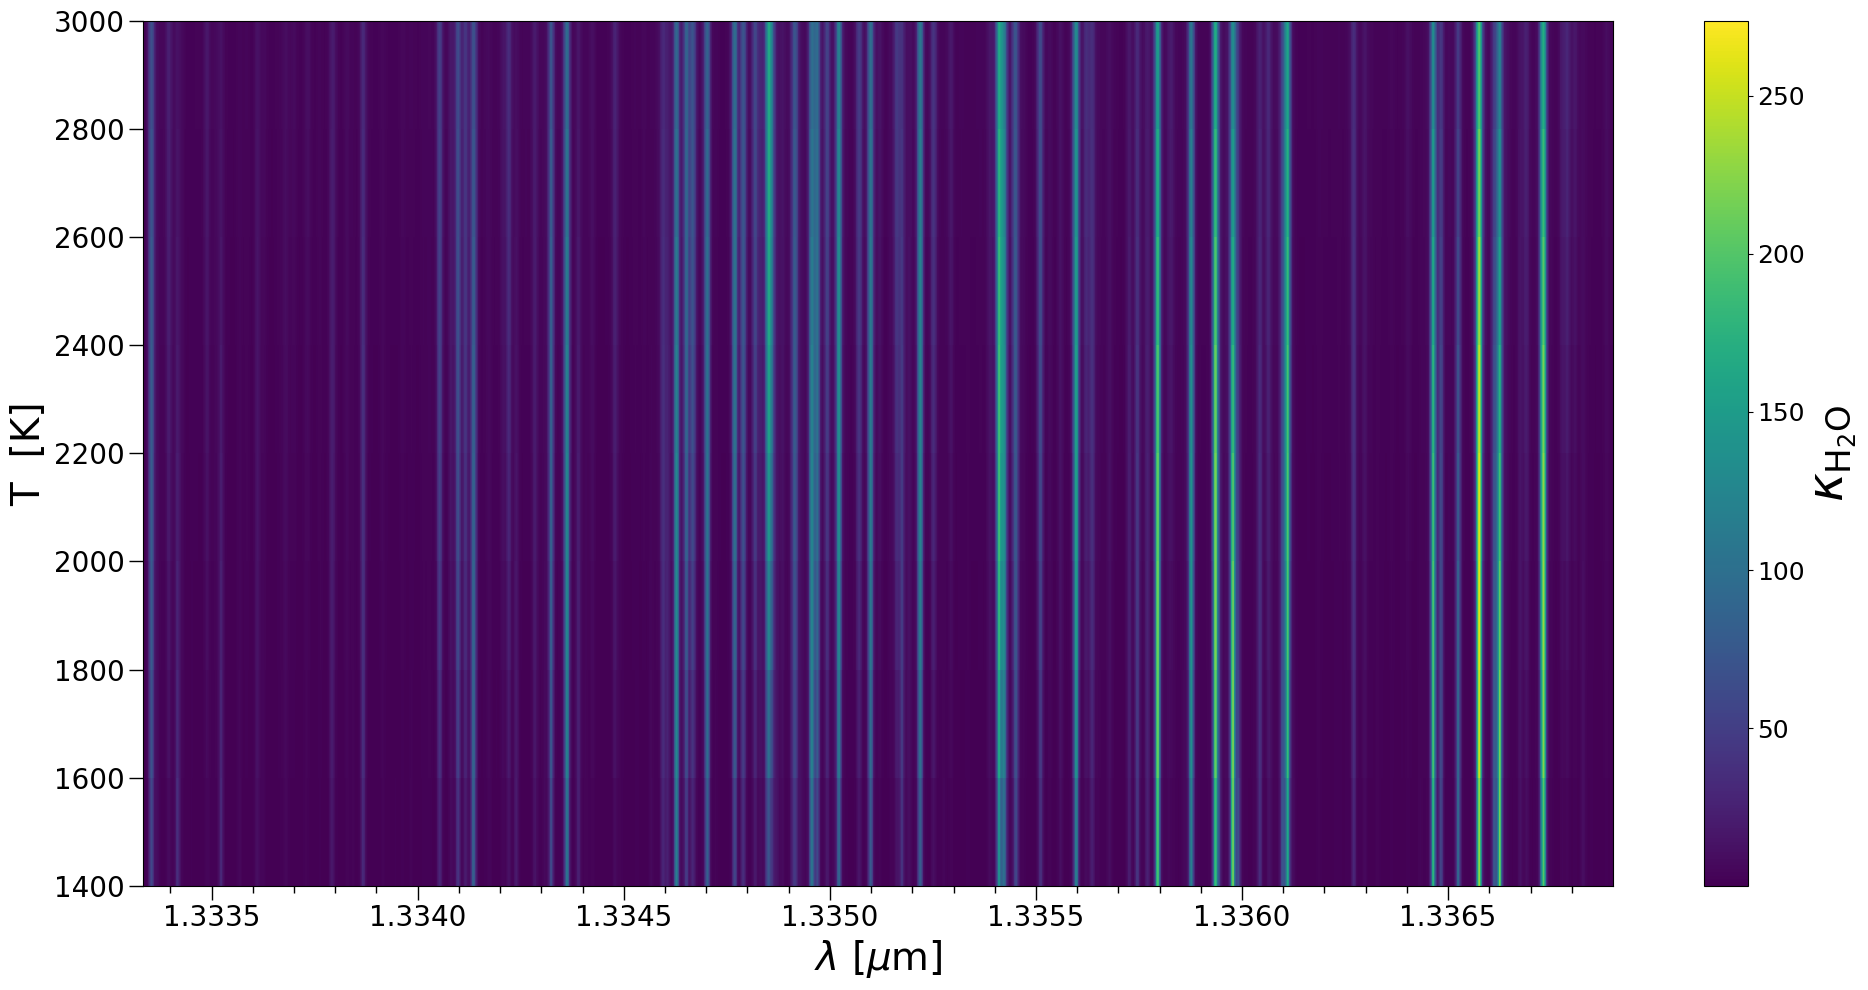

In [3]:
plt.figure(figsize=(20, 10))

# Plotting with pcolormesh
mesh = plt.pcolormesh(wl[-502000: -500000], T_axis, K_H2O[:, -502000: -500000], shading='nearest', cmap='viridis')

# Setting labels and title
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=28)
plt.ylabel('T  [K]', fontsize=28)

# Adding a colorbar to map the opacity values
cbar = plt.colorbar(mesh)
cbar.set_label(r'$\kappa_\mathrm{H_2O}$', fontsize=35)  
cbar.ax.tick_params(labelsize=18)  

# Formatting axis ticks
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

for axx in [ax]:
    axx.xaxis.set_tick_params(labelsize=20)
    axx.yaxis.set_tick_params(labelsize=20)
    axx.xaxis.set_minor_locator(AutoMinorLocator(5))
    axx.tick_params('both', length=10, width=1, which='major')
    axx.tick_params('both', length=5, width=1, which='minor')

plt.tight_layout()
#plt.savefig('opacities2D.pdf', dpi=200, bbox_inches='tight')
plt.show()

Estimation of the transit time

In [4]:
Ts = 5000 
a = np.array([0.01992,0.019]) *const.au.value
Rs = const.R_sun.value
L = 4*np.pi*Rs**2*const.sigma_sb.value*Ts**4
L_ratio = L/const.L_sun.value
M_ratio = L_ratio**(1/4)
Ms = M_ratio*const.M_sun.value

v = np.sqrt(const.G.value*Ms/a)
t = (2*Rs/v)#/(60*60*24*365)
print(t,'yr')

[7084.05367502 6918.53235932] yr


-> highly unrealistic

In [5]:
#unpack .txt format
data_HD209458b = 'Hubble_Denning.txt'
data_WASP12b = 'Hubble_Krenberg.txt'
wavelength_HD209458b, ratio_HD209458b, ratio_err_HD209458b = np.loadtxt(data_HD209458b, usecols=(0,1,2), 
                                                        dtype=np.dtype([('wavelengh_HD209458b',float),
                                                                        ('ratio_HD209458b',float),
                                                                        ('ratio_err_HD209458b',float)]),
                                                                        unpack=True)
wavelength_WASP12b, ratio_WASP12b = np.loadtxt(data_WASP12b, usecols=(0,1), 
                                                        dtype=np.dtype([('wavelenght_WASP12b',float),
                                                                        ('ratio_WASP12b',float)]),
                                                                        unpack=True)

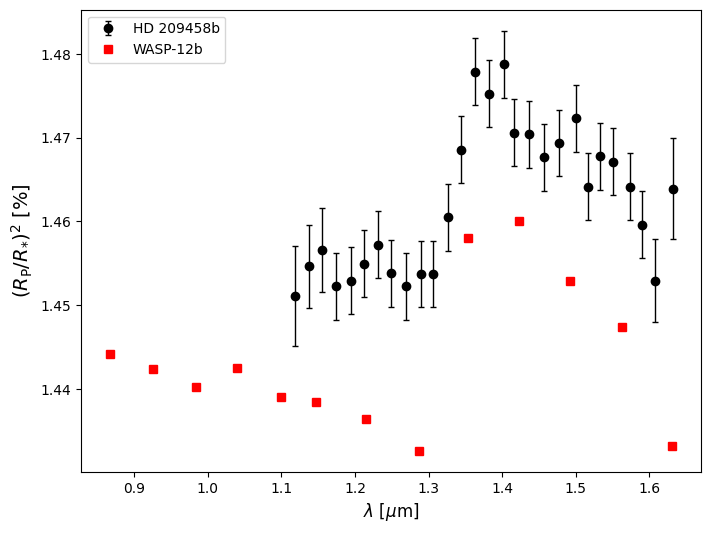

In [6]:
#plot ratio (Rp/R* over wavelength for HD209458b and WASP-12b)
plt.figure(figsize=(8, 6)) 
plt.errorbar(wavelength_HD209458b, 100*ratio_HD209458b, yerr = 100*ratio_err_HD209458b,
             fmt='o', color='black', elinewidth=1, ecolor='black', capsize=2, label='HD 209458b')
plt.errorbar(wavelength_WASP12b, ratio_WASP12b, fmt='s', label='WASP-12b', color='red')
plt.legend(loc='upper left')
plt.xlabel(r'$\lambda \,\,[\mu$m]', fontsize=12)
plt.ylabel(r'$(R_\mathrm{P}/R_{*})^2 \,\, [\%$]', fontsize=14)
#plt.savefig('ratio_over_wl.pdf', dpi=200, bbox_inches='tight')
plt.show()

In [7]:
# Parameters WASP-12b 
R0_W = 1.9 * const.R_jup 
T_W = 1200 * u.K
mu_W = 2.33 *const.u
P0_W = 10 * 1e5 *u.kg /u.m /u.s /u.s
g_W = 43.67 *u.m / u.s / u.s
R_star_W = 1.57 *const.R_sun 

# Parameters HD209458b 
R0_HD = 1.25 *const.R_jup
T_HD = 1500 * u.K
mu_HD = 2.33 *const.u
P0_HD = 10 * 1e5 *u.kg /u.m /u.s /u.s
g_HD = 28.8 *u.m / u.s / u.s
R_star_HD = 1.148 *const.R_sun 

# Common parameters
gamma = 0.57721 #Euler-Masceroni constant
m_CO2 = 44.01 *u.g /const.u
m_H2O = 18.02 *u.g /const.u
kB = const.k_B

In [8]:
#define required functions
def height(T, mu, g):
    const  = kB /mu
    return const * (T / g)
    
def kappa(T, chi_H2O):
    K_H2O_i = interp.interp1d(T_axis, K_H2O.T, bounds_error=False, fill_value=(K_H2O[0], K_H2O[-1]))(T.value).T 
    K_CO2_i = interp.interp1d(T_axis, K_CO2.T, bounds_error=False, fill_value=(K_CO2[0], K_CO2[-1]))(T.value).T
    return (m_H2O * chi_H2O * K_H2O_i) *1e-1*u.m *u.m / u.kg

def radius(R0, H, K, P0, g):
    return R0 + H * (gamma + np.log(K * P0 / g * np.sqrt(2 * np.pi * R0 / H))) 

def transmission(R, Rs):
    return (R / Rs) ** 2 * 100 #return in %

In [25]:
chi_H2O_W = 1.8e-4 *const.u / u.g
chi_H2O_HD = 6.5e-3 *const.u / u.g

k_inter_W = kappa(T_W, chi_H2O_W)
print(np.mean(k_inter_W), np.min(k_inter_W), np.max(k_inter_W))

k_inter_HD = kappa(T_W, chi_H2O_HD)
print(np.mean(k_inter_HD), np.min(k_inter_HD), np.max(k_inter_HD))

0.012364362382904365 m2 / kg 5.392010630574077e-07 m2 / kg 22.601518832812502 m2 / kg
0.4464908638271027 m2 / kg 1.9471149499295278e-05 m2 / kg 816.1659578515624 m2 / kg


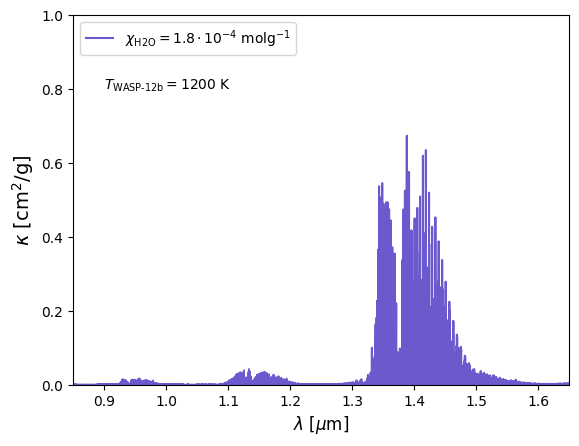

In [26]:
plt.plot(wl, k_inter_W, label=r'$\chi_\mathrm{H2O} = 1.8 \cdot 10^{-4} \,\,\text{molg}$$^{-1}$', color='slateblue', zorder=1)
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$\kappa$ [$\text{cm}^2$/g]', fontsize=14) 
plt.text(0.9, 0.8, r'$T_\text{WASP-12b}=1200$ K')
plt.xlim(0.85,1.65) 
plt.ylim(0,1)
plt.legend(loc='upper left')
#plt.savefig('Opacity_WASP12b.pdf', dpi=200, bbox_inches='tight')

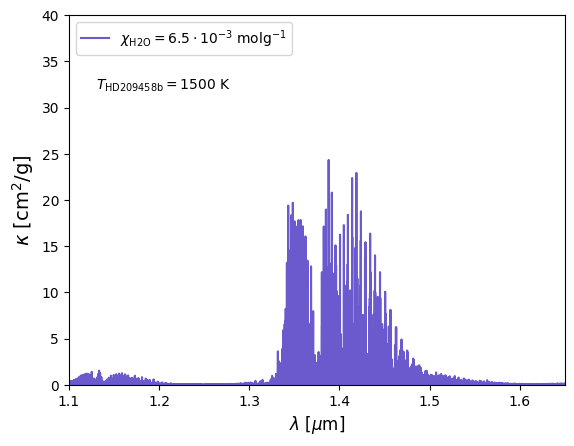

In [27]:
plt.plot(wl, k_inter_HD, label=r'$\chi_\mathrm{H2O} = 6.5 \cdot 10^{-3} \,\,\text{molg}$$^{-1}$', color='slateblue', zorder=1)
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$\kappa$ [$\text{cm}^2$/g]', fontsize=14) 
plt.text(1.13, 32, r'$T_\text{HD209458b}=1500$ K')
plt.xlim(1.1,1.65)
plt.ylim(0,40)
plt.legend(loc='upper left')
#plt.savefig('Opacity_HD209458b.pdf', dpi=200, bbox_inches='tight')

In [28]:
#WASP-12b
chi_H2O_W = 1.8e-4 *const.u / u.g

#calc of transmission for WASP-12b
transmission_W = transmission(radius(R0_W.value, 
                                     height(T_W, mu_W, g_W).value, 
                                     kappa(T_W, chi_H2O_W).value, 
                                     P0_W.value, g_W.value),
                              R_star_W.value)

#HD209458b 
chi_H2O_HD = 6.5e-3 *const.u / u.g

#calc of transmission for HD209458b
transmission_HD = transmission(radius(R0_HD.value, 
                                      height(T_HD, mu_HD, g_HD).value, 
                                      kappa(T_HD, chi_H2O_HD).value, 
                                      P0_HD.value, g_HD.value), 
                               R_star_HD.value)

In [29]:
transmission_HD

array([1.32431366, 1.33041189, 1.33697623, ..., 1.29728204, 1.29767576,
       1.2976838 ])

In [30]:
#binning to better fit by eye
# WASP-12b:
n_bins = 5000
min_wl_W, max_wl_W = wavelength_WASP12b.min(), wavelength_WASP12b.max()

mask_W = (wl >= min_wl_W) & (wl <= max_wl_W)
cut_wl_W = wl[mask_W]
cut_transmission_W = transmission_W[mask_W]

bins = np.linspace(min_wl_W, max_wl_W, n_bins)
bin_indices = np.digitize(cut_wl_W, bins)

bin_wl_W = []
bin_transmission_W = []
for i in range(1, len(bins)):
    bin_mask = bin_indices == i
    if np.any(bin_mask):
        bin_wl_W.append(cut_wl_W[bin_mask].mean())
        bin_transmission_W.append(cut_transmission_W[bin_mask].mean())

wl_binned_W = np.array(bin_wl_W)
transmission_binned_W = np.array(bin_transmission_W)

# HD 209458b:
n_bins = 3000
min_wl_HD, max_wl_HD = wavelength_HD209458b.min(), wavelength_HD209458b.max()

mask_HD = (wl >= min_wl_HD) & (wl <= max_wl_HD)
cut_wl_HD = wl[mask_HD]
cut_transmission_HD = transmission_HD[mask_HD]

bins = np.linspace(min_wl_HD, max_wl_HD, n_bins)
bin_indices = np.digitize(cut_wl_HD, bins)

wl_binned_HD = []
bin_transmission_HD = []
for i in range(1, len(bins)):
    bin_mask = bin_indices == i
    if np.any(bin_mask):
        wl_binned_HD.append(cut_wl_HD[bin_mask].mean())
        bin_transmission_HD.append(cut_transmission_HD[bin_mask].mean())

wl_binned_HD = np.array(wl_binned_HD)
transmission_binned_HD = np.array(bin_transmission_HD)

In [31]:
transmission_binned_HD

array([1.30365638, 1.30277374, 1.30028248, ..., 1.30191194, 1.30505108,
       1.30647318])

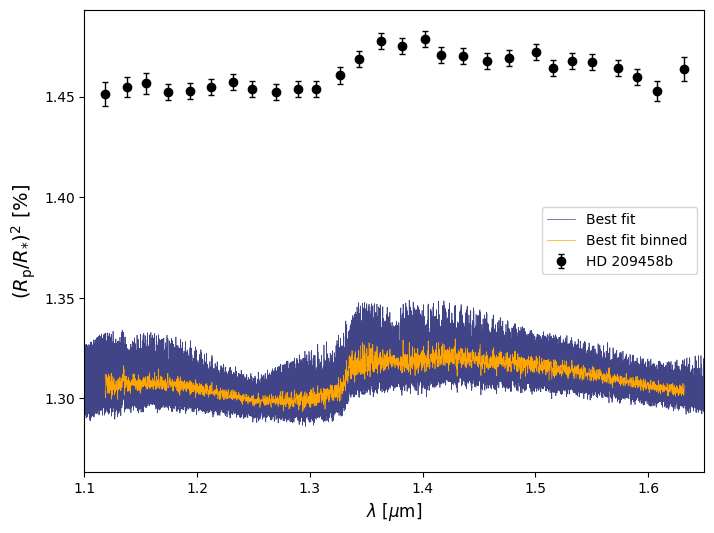

In [32]:
#plot HD 
plt.figure(figsize=(8, 6))  
plt.errorbar(wavelength_HD209458b, 100*ratio_HD209458b, yerr = 100*ratio_err_HD209458b, 
             fmt='o', color='black', elinewidth=1, ecolor='black', capsize=2, label='HD 209458b', zorder=3)
plt.plot(wl, transmission_HD, color=cm.viridis(0.2), linewidth=0.5, label='Best fit ', zorder=1)
plt.plot(wl_binned_HD, transmission_binned_HD, color='orange', linewidth=0.5, label='Best fit binned ', zorder=4)

#cosmetics
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$(R_\mathrm{p} / R_{*})^2 \,\, [\%]$', fontsize=14)  
plt.xlim(1.1,1.65) 
plt.legend(loc='center right')
#plt.savefig('HD209458b_emission_bestfit.pdf', dpi=200, bbox_inches='tight')
plt.show()

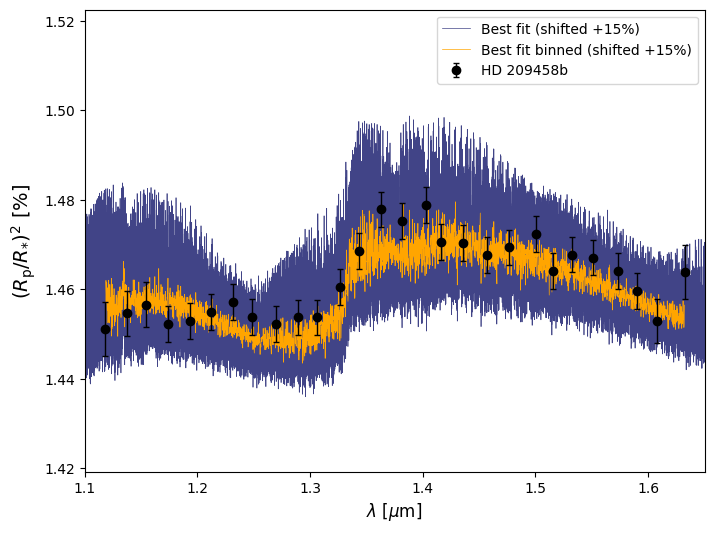

In [33]:
#Model shifted to data
#plot HD 
plt.figure(figsize=(8, 6))  
plt.errorbar(wavelength_HD209458b, 100*ratio_HD209458b, yerr = 100*ratio_err_HD209458b, 
             fmt='o', color='black', elinewidth=1, ecolor='black', capsize=2, label='HD 209458b', zorder=3)
plt.plot(wl, transmission_HD+0.15, color=cm.viridis(0.2), linewidth=0.5, label='Best fit (shifted +15%)', zorder=1)
plt.plot(wl_binned_HD, transmission_binned_HD+0.15, color='orange', linewidth=0.5, label='Best fit binned (shifted +15%)', zorder=2)

#cosmetics
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$(R_\mathrm{p} / R_{*})^2 \,\, [\%]$', fontsize=14)  
plt.xlim(1.1,1.65) 
plt.legend()
#plt.savefig('HD209458b_emission_bestfit_shifted.pdf', dpi=200, bbox_inches='tight')
plt.show()

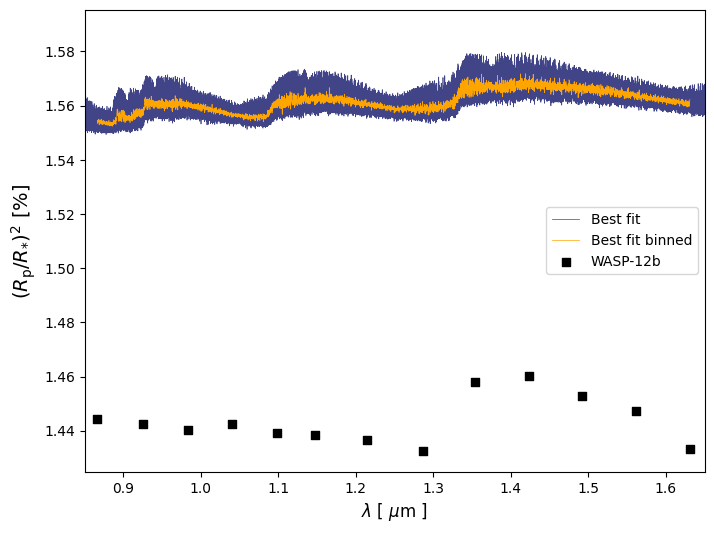

In [34]:
#plot WASP-12b
plt.figure(figsize=(8, 6))  
plt.plot(wl, transmission_W, color=cm.viridis(0.2), linewidth=0.5, label='Best fit', zorder=1)
plt.plot(wl_binned_W, transmission_binned_W, color='orange', linewidth=0.5, label='Best fit binned', zorder=2)
plt.scatter(wavelength_WASP12b, ratio_WASP12b, marker='s', color='black', label='WASP-12b', zorder=3)

#cosmetics
plt.xlabel(r'$\lambda$ [ $\mu$m ]', fontsize=12)  
plt.ylabel(r'$(R_\mathrm{p} / R_{*})^2 \,\, [\%]$', fontsize=14)  
plt.xlim(0.85,1.65) 
#plt.ylim(1,5)
plt.legend()
#plt.savefig('WASP12b_emission_bestfit.pdf', dpi=200, bbox_inches='tight')
plt.show()

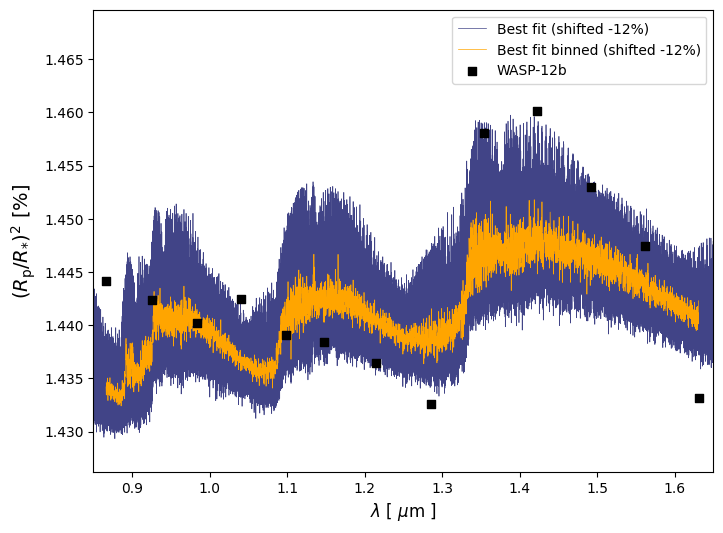

In [35]:
#Model shifted to data
#plot WASP-12b
plt.figure(figsize=(8, 6))  
plt.plot(wl, transmission_W-0.12, color=cm.viridis(0.2), linewidth=0.5, label='Best fit (shifted -12%)', zorder=1)
plt.plot(wl_binned_W, transmission_binned_W-0.12, color='orange', linewidth=0.5, label='Best fit binned (shifted -12%)', zorder=2)
plt.scatter(wavelength_WASP12b, ratio_WASP12b, marker='s', color='black', label='WASP-12b', zorder=3)

#cosmetics
plt.xlabel(r'$\lambda$ [ $\mu$m ]', fontsize=12)  
plt.ylabel(r'$(R_\mathrm{p} / R_{*})^2 \,\, [\%]$', fontsize=14)  
plt.xlim(0.85,1.65) 
#plt.ylim(1,5)
plt.legend()
#plt.savefig('WASP12b_emission_bestfit_shifted.pdf', dpi=200, bbox_inches='tight')
plt.show()

Try different $\chi_\text{H2O}$-values

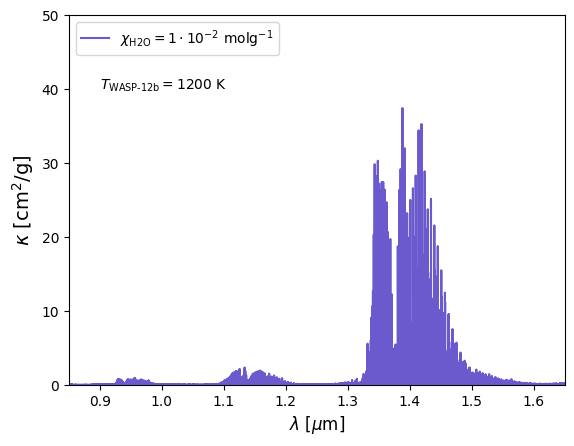

In [36]:
chi_H2O_W2 = 1e-2 *const.u / u.g
k_inter2 = kappa(T_W, chi_H2O_W2)
plt.plot(wl, k_inter2, label=r'$\chi_\mathrm{H2O} = 1 \cdot 10^{-2} \,\,\text{molg}$$^{-1}$', color='slateblue', zorder=1)
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$\kappa$ [$\text{cm}^2$/g]', fontsize=14) 
plt.text(0.9, 40, r'$T_\text{WASP-12b}=1200$ K')
plt.xlim(0.85,1.65) 
plt.ylim(0,50)
plt.legend(loc='upper left')
#plt.savefig('Opacity_WASP12b_chiH2O_1emin2.pdf', dpi=200, bbox_inches='tight')

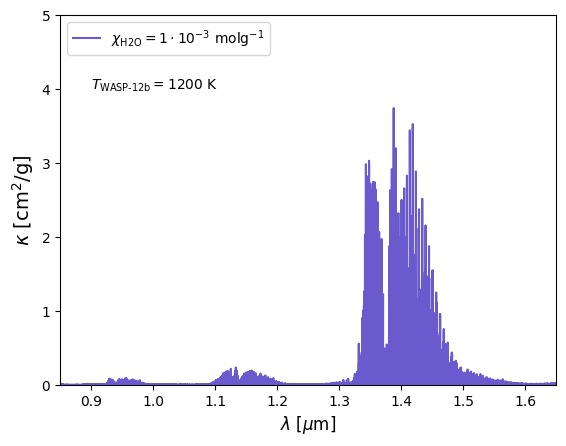

In [37]:
chi_H2O_W2 = 1e-3 *const.u / u.g
k_inter2 = kappa(T_W, chi_H2O_W2)
plt.plot(wl, k_inter2, label=r'$\chi_\mathrm{H2O} = 1 \cdot 10^{-3} \,\,\text{molg}$$^{-1}$', color='slateblue', zorder=1)
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$\kappa$ [$\text{cm}^2$/g]', fontsize=14) 
plt.text(0.9, 4, r'$T_\text{WASP-12b}=1200$ K')
plt.xlim(0.85,1.65) 
plt.ylim(0,5)
plt.legend(loc='upper left')
#plt.savefig('Opacity_WASP12b_chiH2O_1emin3.pdf', dpi=200, bbox_inches='tight')

Dimensional and order of magnitude tries

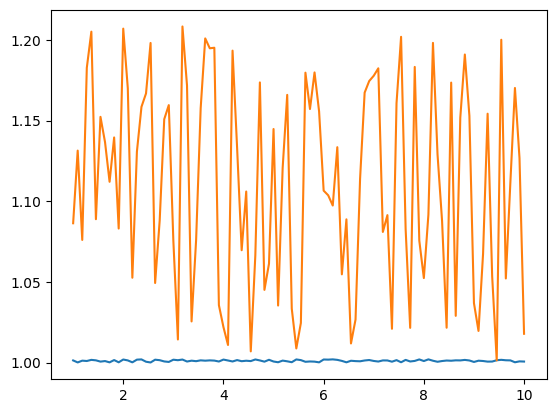

In [38]:
x= np.linspace(1,10,100)
y = 1e8 + np.linspace(1,1.001,100)*1e5*np.random.rand(100)
y1 = 1e8 + np.linspace(1,1.001,100)*1e7*np.random.rand(100)
ratio = (y/1e9)**2 *100
ratio1 = (y1/1e9)**2 *100
plt.plot(x,ratio)
plt.plot(x,ratio1)

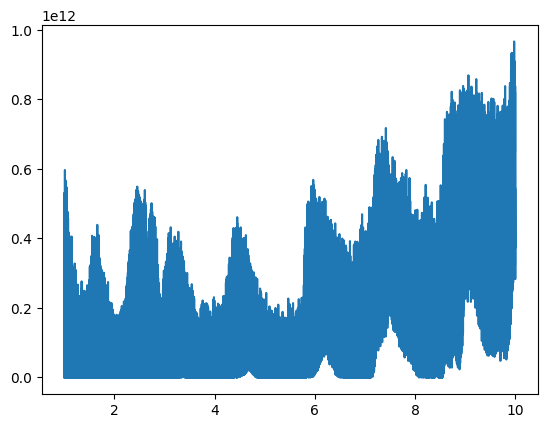

In [41]:
x= np.linspace(1,10,100)
y = 1e8 + np.linspace(1,1.1,100)*1e5*np.random.rand(100)
x1 = np.linspace(1,10,1068181)
y1= 1e7* 1e5*np.log(kappa(T_W, chi_H2O_W).value*1e2)
ratio = (y/1e8)**2 *100
ratio1 = (y1/1e8)**2 *100
#plt.plot(x,ratio)
plt.plot(x1,ratio1)
#plt.scatter(wavelength_WASP12b, ratio_WASP12b, marker='s', color='black', label='WASP-12b', zorder=2)
#plt.xlim(0.8,1.65) 
#plt.ylim((1.4**12,1.5**12))

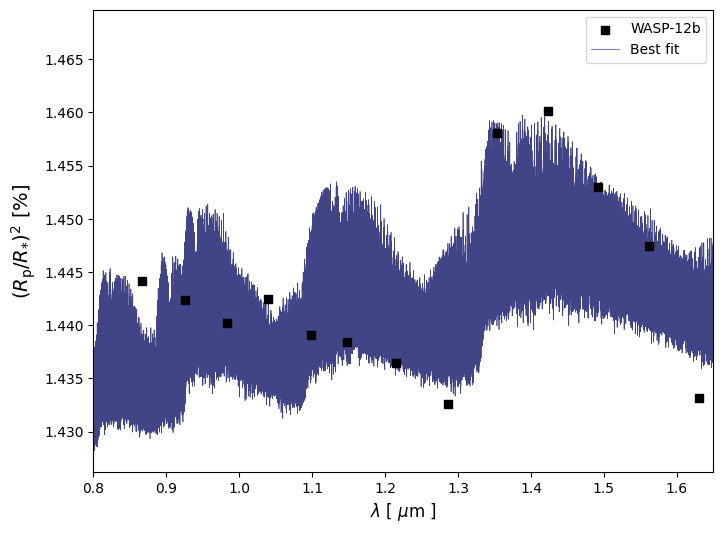

In [42]:
#plot WASP-12b
plt.figure(figsize=(8, 6))  
plt.scatter(wavelength_WASP12b, ratio_WASP12b, marker='s', color='black', label='WASP-12b', zorder=2)
plt.plot(wl, transmission_W-0.12, color=cm.viridis(0.2), linewidth=0.5, label='Best fit', zorder=1)

#cosmetics
plt.xlabel(r'$\lambda$ [ $\mu$m ]', fontsize=12)  
plt.ylabel(r'$(R_\mathrm{p} / R_{*})^2 \,\, [\%]$', fontsize=14)  
plt.xlim(0.8,1.65) 
#plt.ylim(1,5)
plt.legend()
#plt.savefig('WASP_emission.pdf', dpi=200, bbox_inches='tight')
plt.show()

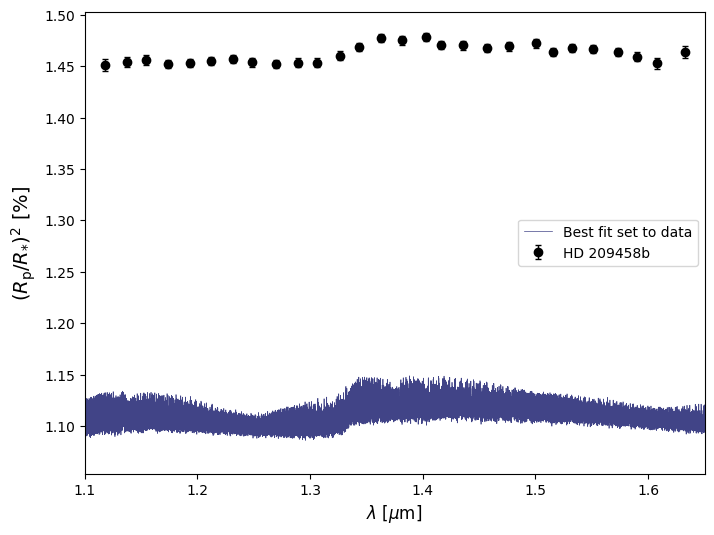

In [43]:
#plot HD 
plt.figure(figsize=(8, 6))  
plt.errorbar(wavelength_HD209458b, 100*ratio_HD209458b, yerr = 100*ratio_err_HD209458b, 
             fmt='o', color='black', elinewidth=1, ecolor='black', capsize=2, label='HD 209458b', zorder=2)
plt.plot(wl, transmission_HD-0.2, color=cm.viridis(0.2), linewidth=0.5, label='Best fit set to data', zorder=1)

#cosmetics
plt.xlabel(r'$\lambda$ [$\mu$m]', fontsize=12)  
plt.ylabel(r'$(R_\mathrm{p} / R_{*})^2 \,\, [\%]$', fontsize=14)  
plt.xlim(1.1,1.65) 
plt.legend()
#plt.savefig('HD209458b_emission.pdf', dpi=200, bbox_inches='tight')
plt.show()